In [8]:
import pandas as pd

train_data = pd.read_csv('../data/train.csv')
train_data.shape

(14409, 2401)

In [9]:
X_train, y_train = train_data.drop('Class', axis=1), train_data['Class']
print(X_train)
print(y_train)

            x1      y1  xVel1  yVel1   xA1  ...  yS200  xC200  yC200  nAC200  nS200
0      -665.32 -307.31  -8.35  -0.17 -0.56  ...    0.0  -0.31   0.09      32      0
1       741.37  895.65   8.05  13.52  0.00  ...    0.0   0.00   0.00      10      0
2      -255.72 -934.51 -11.62  -4.70  0.00  ...    0.0   0.00   0.00      16      0
3       295.64  913.03   0.02  11.30 -0.17  ...    0.0   0.00   0.00      14      0
4       975.62 -133.05  -0.30   8.19 -0.04  ...    0.0   0.02   1.00      14      4
...        ...     ...    ...    ...   ...  ...    ...    ...    ...     ...    ...
14404   258.90 -697.48 -12.69   0.00  1.00  ...    0.0   1.97   1.82       7      0
14405   972.02 -290.78  -7.05  -0.92 -0.99  ...    0.0  -0.87   0.49       6      1
14406  1353.72 -529.07   1.21   8.21 -0.01  ...    0.0   0.00   0.00       0      0
14407  -981.55 -624.82 -14.96  -6.05  0.00  ...    0.0   0.00   0.00      29      0
14408   144.76  280.85  -9.32  -2.19 -0.98  ...    0.0  -0.98   0.19       1

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train, y_train)
X_scaled

array([[-0.90806221, -0.41188536, -1.17614539, ...,  0.01711812,
         0.15636752, -0.28972054],
       [ 0.76154574,  1.69288541,  1.3788869 , ..., -0.1289564 ,
        -0.48501791, -0.28972054],
       [-0.42190576, -1.509272  , -1.68559391, ..., -0.1289564 ,
        -0.31009461, -0.28972054],
       ...,
       [ 1.48834725, -0.79988992,  0.31325148, ..., -0.1289564 ,
        -0.77655674, -0.28972054],
       [-1.2833973 , -0.96741985, -2.20594804, ..., -0.1289564 ,
         0.06890587, -0.28972054],
       [ 0.05342611,  0.61719456, -1.32726621, ...,  0.17942313,
        -0.74740286, -0.28972054]])

In [11]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.5)
X_vt = vt.fit_transform(X_scaled)
X_vt.shape, vt.get_support().sum()

((14409, 2400), np.int64(2400))

In [12]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi = SelectKBest(score_func=mutual_info_classif, k=200)
X_mi = mi.fit_transform(X_vt, y_train)

print(mi.scores_)

[0.03904283 0.0242733  0.31323472 ... 0.24699215 0.09133653 0.10094842]


In [26]:
import numpy as np

np.save('../output/mutual_info.npy', mi.scores_)

In [49]:
from sklearn.feature_selection import SelectKBest

class CachedSelectKBestMI(SelectKBest):
    def __init__(self, k, scores, score_func=mutual_info_classif):
        super().__init__(k=k, score_func=score_func)
        self.scores_ = scores

    def fit(self, X, y):
        self._check_params(X, y)
        mask = np.zeros(len(self.scores_), dtype=bool)
        top_k_indices = np.argsort(self.scores_)[::-1][:self.k]
        mask[top_k_indices] = True
        self._mask = mask

        return self

In [27]:
mi_scores = np.load('../output/mutual_info.npy')
mi_scores.flatten()

array([0.03904283, 0.0242733 , 0.31323472, ..., 0.24699215, 0.09133653,
       0.10094842])

In [65]:
mi_k = 500
mi = CachedSelectKBestMI(k=mi_k, scores=mi_scores.flatten())
X_mi = mi.fit_transform(X_vt, y_train)
print(X_mi, X_mi.shape)

[[-1.17614539 -0.02503601 -0.50080701 ... -0.01157105 -1.16616067
   0.43763312]
 [ 1.3788869   1.83549796  0.0664917  ...  1.33428245  0.89795412
   1.2642409 ]
 [-1.68559391 -0.64068384  0.0664917  ... -0.71046056 -1.23367056
  -2.17801777]
 ...
 [ 0.31325148  1.11384454  0.68697466 ...  1.00027502  0.17897382
   1.14005569]
 [-2.20594804 -0.82415505  0.0664917  ... -1.42759418  0.07602124
  -0.28678058]
 [-1.32726621 -0.2995633  -1.67086059 ... -0.34136831 -1.23029507
   0.28498881]] (14409, 500)


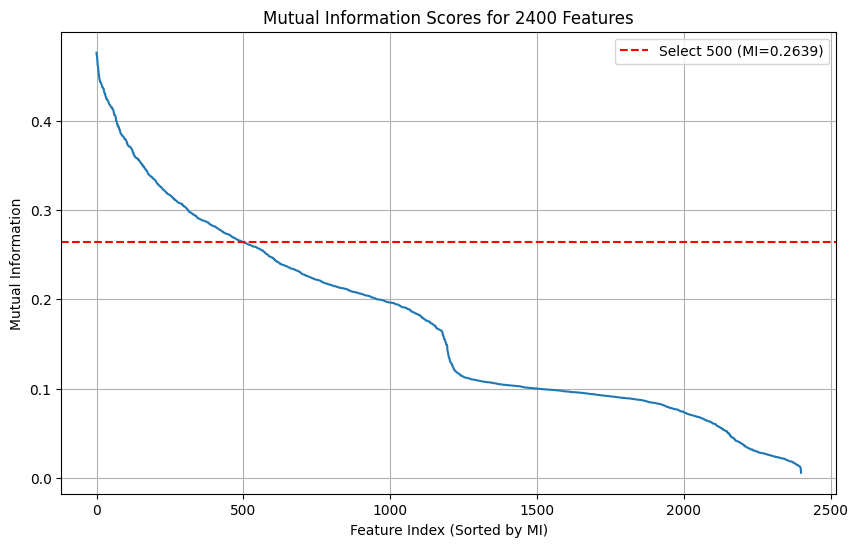

Number of features: 2400
Max MI: 0.4759
Min MI: 0.0059
Select 500 MI: 0.2639


In [66]:
import numpy as np
import matplotlib.pyplot as plt

sorted_mi = np.sort(mi.scores_)[::-1]
indices = np.arange(len(sorted_mi))

plt.figure(figsize=(10, 6))
plt.plot(indices, sorted_mi, linestyle='-')
plt.xlabel("Feature Index (Sorted by MI)")
plt.ylabel("Mutual Information")
plt.title("Mutual Information Scores for 2400 Features")
plt.grid(True)

threshold = np.percentile(sorted_mi, 100 - mi_k/24)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Select {mi_k} (MI={threshold:.4f})')
plt.legend()

plt.show()

print(f"Number of features: {len(sorted_mi)}")
print(f"Max MI: {np.max(sorted_mi):.4f}")
print(f"Min MI: {np.min(sorted_mi):.4f}")
print(f"Select {mi_k} MI: {threshold:.4f}")

In [67]:
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

# Custom correlation filter
class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.selected_features_ = None
        self.scores_ = None
        self.mask_ = None

    def fit(self, X, y=None):
        corr_matrix = np.abs(np.corrcoef(X, rowvar=False))
        self.scores_ = corr_matrix
        self.selected_features_ = np.arange(X.shape[1])
        keep_features = []
        for i in range(X.shape[1]):
            if i in self.selected_features_:
                keep_features.append(i)
                correlated_features = np.where(corr_matrix[i] > self.threshold)[0]
                self.selected_features_ = np.setdiff1d(self.selected_features_, correlated_features)
        self.selected_features_ = np.array(keep_features)
        mask = np.zeros(X.shape[1], dtype=bool)
        mask[self.selected_features_] = True
        self.mask_ = mask
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

    def get_support(self):
        return self.mask_

In [70]:
ct = CorrelationThreshold(threshold=0.7)
X_ct = ct.fit_transform(X_mi)
print(f'Number of remaining features:{ct.get_support().sum()}')
print(f'Selected {ct.get_support().sum()} features:\n{ct.selected_features_}')
print(f'Correlation scores:\n{ct.scores_}')

Number of remaining features:404
Selected 404 features:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  27  28  29  30  31  32  33  34  35  36
  38  39  40  42  43  44  45  46  47  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  68  69  70  71  72  73  76  77  78  79  80
  81  82  83  85  87  88  90  91  92  93  94  95  97  98 100 101 102 103
 104 105 106 107 108 109 110 112 113 115 116 117 118 120 121 122 123 124
 125 126 127 128 129 131 132 133 134 135 136 137 138 139 140 142 143 144
 145 147 148 149 150 151 152 154 156 157 158 160 161 163 164 165 166 167
 168 170 171 172 173 174 175 177 178 179 180 181 182 183 184 185 186 187
 188 189 191 192 193 194 195 197 198 200 201 203 204 206 208 209 211 212
 213 214 215 216 218 219 220 222 223 225 226 228 229 230 231 233 234 235
 236 238 239 240 241 243 244 245 246 247 248 250 251 253 255 257 258 259
 260 261 262 263 264 265 266 267 269 271 272 273 274 276 277 279 280

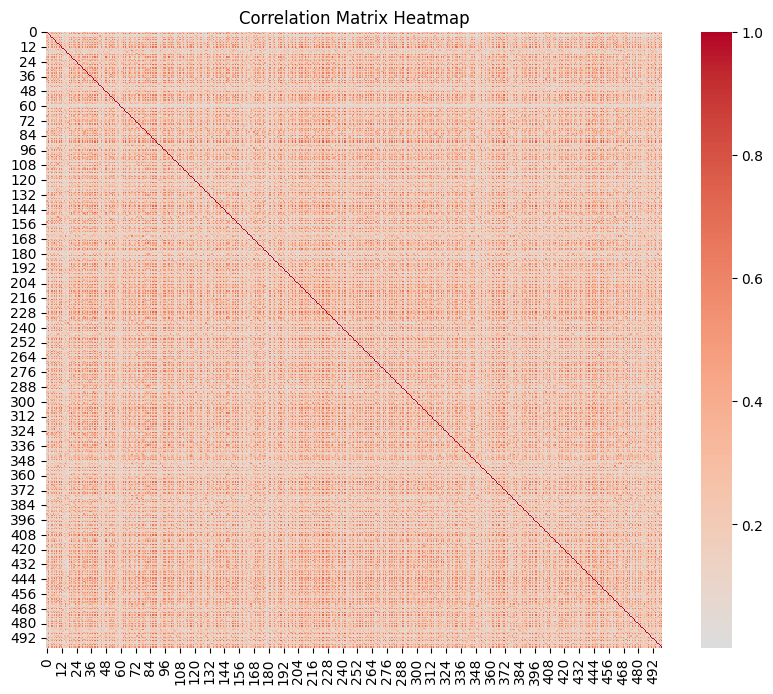

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(ct.scores_, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()